In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import metrics
import utils

# Introduction

Let $X \in \mathbb{R}^p$ vector of features. We can transform it to a vector of size $P$, using transformations functions $h_m(X) : \mathbb{R}^p \to \mathbb{R}$.  
The functions might be non linear, but we can still use a linear model on thre transformed input:

$$F(X) = \sum_{m=1}^M \beta_m h_m(X)$$

Basic $h_m$ examples:

- linear: $h_m(X) = X_m$
- polylonials: $h_m(X) = X_j^2$ or  $h_m(X) = X_jX_k$
- other non-linearaties: $h_m(X) = \log X_j$ or $h_m(X) = \sqrt{X_j}$
- indicator: $h_m(X) = I(L_m \leq X_k \leq U_m)$. Result in a model with piecewise constant contribution of different regions

# Piecewise Polynomials and Splines

In [2]:
N = 100
X = np.random.randn(100, 2)
y = (X[:,0] + X[:,1] + 0.2*np.random.randn(len(X)) > 0).astype(np.int)

Accuracy: 0.94


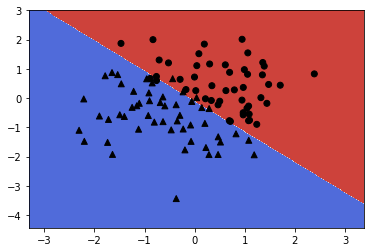

In [3]:
#Linear Modeal

clf = LogisticRegression(solver='liblinear')
clf.fit(X, y)
pred = clf.predict(X)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=None, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

Accuracy: 0.94


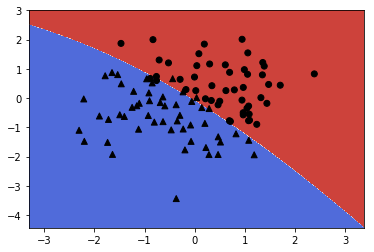

In [4]:
#Polynomial model (d=2)

def poly_features(X):
    return np.concatenate((
        X, X[:, 0:1]*X[:,1:2], X[:,0:1]**2, X[:,1:2]**2
    ), axis=1)    

Xe = poly_features(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xe, y)

pred = clf.predict(Xe)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=poly_features, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

Accuracy: 0.78


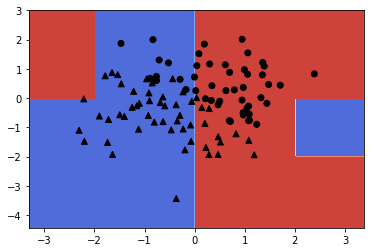

In [5]:
#Piecewise constant: 4 piece

def piecewise_constant(X, i1, i2):
    n = len(X)
    Xe = np.empty((n, len(i1) + len(i2) + 2))
    
    for i in range(Xe.shape[1]):
        if i <= len(i1):
            data = X[:, 0]
            pos = i
            inters = i1
        else:
            data = X[:, 1]
            pos = i - len(i1) - 1
            inters = i2
        
        if pos == 0:
            Xe[:,i] = (data < inters[0]).astype(np.int)
        elif pos == len(inters):
            Xe[:,i] = (data > inters[-1]).astype(np.int)
        else:
            Xe[:,i] = ((data >= inters[pos-1]) & (data <= inters[pos])).astype(np.int)
        
    
    
    return Xe

def transf(X): return piecewise_constant(X, [-2, 0, 2], [-2, 0, 2])

Xe = transf(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xe, y)

pred = clf.predict(Xe)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=transf, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

Accuracy: 0.93


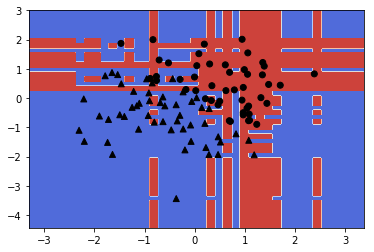

In [6]:
#piecewise constant: 50 pieces

def transf(X): return piecewise_constant(X, 
                                         np.linspace(-4, 4, 50),
                                         np.linspace(-4, 4, 50))

Xe = transf(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xe, y)

pred = clf.predict(Xe)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=transf, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

For piecewise constant, the functions are indacators:

$$h_1(X) = I(X \leq \lambda_1), \space h_2(X) = I(\lambda_1 \leq X \leq \lambda_2), \space I(\lambda_2 \leq X)$$

$$f(X) = \sum_{i=1}^3 \beta_m h_m(X)$$

With $\beta_m = \bar{y}_m$, the mean of $y$ in the $m$-th region.

To make the model the piewise linear, we need to add 3 more contrains:
$$h_{m+3} = h_m(X)X$$

If we want to have a continous model, we need to add constraints:

$$f(\lambda_1^-) = f(\lambda_1^+)$$
$$\beta_1 + \lambda_1 \beta_4 = \beta_2 + \lambda_1 \beta_5$$

These constraints can be forced using a specific basis:

$$h_1(X) = 1, h_2(X) = X, h_3(X) = (X - \lambda_1)_+, h_4(X) = (X - \lambda_2)_+$$

In [7]:
NR = 50
Xr = 0.2*np.random.randn(NR,1)**2 + 1.5*np.random.randn(NR,1) + 0.3
yr = 4.5*Xr[:,0] - 3.3*Xr[:,0]**2 + 1.8*Xr[:,0]**3 + 1.3 + 0.1*np.random.randn(len(Xr))

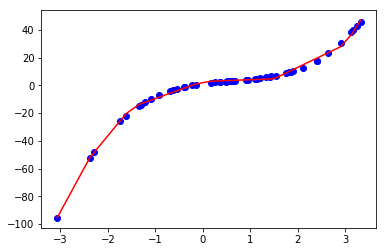

In [8]:
def piecewise_linear(X, inters):
    Xe = np.empty((len(X), 2 + len(inters)))
    Xe[:,0] = np.ones(len(X))
    Xe[:,1] = X[:,0]
    for i in range(len(inters)):
        Xe[:,i+2] = np.maximum(X[:, 0] - inters[i], 0)
    return Xe

Xe = piecewise_linear(Xr, np.linspace(-3, 3, 5))

beta = np.linalg.inv(Xe.T @ Xe) @ Xe.T @ yr
preds = Xe @ beta

utils.plot_reg(Xr, yr, preds)
plt.show()

Accuracy: 0.97


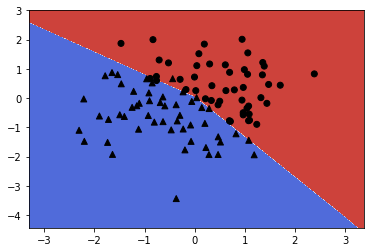

In [9]:
#piecewise linear: 3 pieces

def transf(X):
    X0 = piecewise_linear(X[:,0:1], np.linspace(-4, 4, 3))
    X1 = piecewise_linear(X[:,1:2], np.linspace(-4, 4, 3))[:, 1:]
    return np.concatenate((X0, X1), axis=1)

Xe = transf(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xe, y)

pred = clf.predict(Xe)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=transf, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

We can create continous piecewise continous polynomials, called order-$M$ spines:

$$h_j(X) = X^{j-1}, j=1,\text{...},M$$
$$h_{M+l}(X) = (X - \lambda_l)_+^{M-1}, l=1,\text{...},L$$

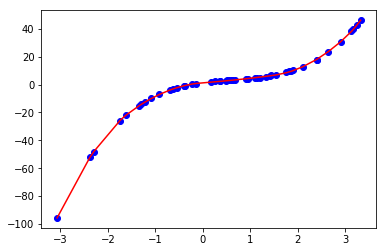

In [10]:
def spline(X, inters, M):

    Xe = np.empty((len(X), M + len(inters)))
    
    for i in range(M):
        Xe[:,i] = X[:,0]**i
    
    for i in range(len(inters)):
        Xe[:,M+i] = np.maximum(X[:, 0] - inters[i], 0)**(M-1)
    return Xe
    
Xe = spline(Xr, np.linspace(-3, 3, 5), 3)

beta = np.linalg.inv(Xe.T @ Xe) @ Xe.T @ yr
preds = Xe @ beta

utils.plot_reg(Xr, yr, preds)
plt.show()

Accuracy: 0.94


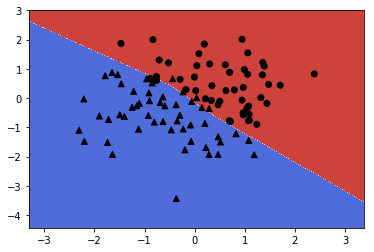

In [11]:
#spine of order 4 with 3 pieces

def transf(X):
    X0 = spline(X[:,0:1], np.linspace(-4, 4, 3), 4)
    X1 = spline(X[:,1:2], np.linspace(-4, 4, 3), 4)[:, 1:]
    return np.concatenate((X0, X1), axis=1)

Xe = transf(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xe, y)

pred = clf.predict(Xe)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=transf, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

The basic splines adds a lot of variance to the estimate.  

One solution is to make linear predictions outside the boundaries, it increases the degrees of freedom, and helps being more precise in the interior region.

A natural cubic spine with $K$ knots is represented by:

$$h_1(X) = 1$$
$$h_2(X) = X$$
$$h_{k+2}(X) = d_k(X) - d_{K-1}(X) \space k=3,\text{...},K-2$$

$$\text{width } d_k(X) = \frac{(X - \lambda_k)^3_+ - (X - \lambda_K)^3_+}{\lambda_K - \lambda_k}$$

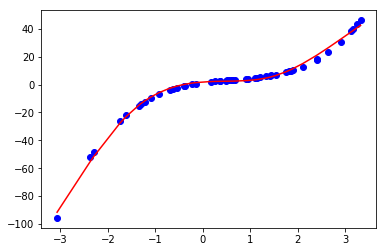

In [12]:
def natural_spline(X, inters):

    def dk(k):
        p1 = np.maximum(X[:, 0] - inters[k], 0)**3
        p2 = np.maximum(X[:, 0] - inters[-1], 0)**3
        return (p1 - p2) / (inters[-1] - inters[k])
    
    dk1 = dk(len(inters)-2)
              
    Xe = np.empty((len(X), len(inters)))
    Xe[:,0] = np.ones(len(X))
    Xe[:,1] = X[:,0]
    
    for i in range(len(inters) - 2):
        Xe[:,2+i] = dk(i) - dk1
    
    return Xe
    
Xe = natural_spline(Xr, np.linspace(-3, 3, 5))

beta = np.linalg.inv(Xe.T @ Xe) @ Xe.T @ yr
preds = Xe @ beta

utils.plot_reg(Xr, yr, preds)
plt.show()

Accuracy: 0.96


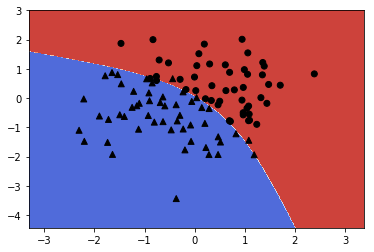

In [13]:
#natural spine of order 3 with 10 pieces

def transf(X):
    X0 = natural_spline(X[:,0:1], np.linspace(-4, 4, 10))
    X1 = natural_spline(X[:,1:2], np.linspace(-4, 4, 10))[:, 1:]
    return np.concatenate((X0, X1), axis=1)

Xe = transf(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xe, y)

pred = clf.predict(Xe)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=transf, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

# Smoothing Splines

Find the function $f$ that minimizes the penalized residual sum of squares:
    
$$RSS(f, \lambda) = \sum_{i=1}^N (y_i - f(x_i))^2 + \lambda \int f''(t)^2dt$$

Take $f$ a function representatic a natural cubic spine, with one knot of each of the $N$ points in $X$:

$$f(x) = \sum_{j=1}^N N_j(x)\beta_j$$

with $N_j(x)$ set of basis functions for the natural spline

the residual can be rewritten as:

$$RSS(\beta, \lambda) = (y - N\beta)^T (y - N \beta) + \lambda \beta^T \Omega \beta$$

with $N_{ij} = N_j(x_i)$ and $\Omega_{jk} = \int N_j''(t) N_k''(t)dt$

The solution is:

$$\hat{\lambda} = (N^TN + \lambda \Omega)^{-1}N^Ty$$

Let $\hat{f}$ vector of predictions.

$$\hat{f} = N(N^TN + \lambda \Omega)^{-1}N^Ty$$
$$\hat{f} = S_\lambda y$$

The fit is linear in $y$, and the finite linear operator $S_\lambda$ is called the smoother matrix.  

The effective degrees of freedom of smoothing pline is:
$$\text{df}_\lambda = \text{trace}(S_\lambda)$$

# Automatic Selection of the Smoothing Parameters

The only parameter is $\lambda$, and in practice the spine is almost always cubic.

We can chose the degress of freedom $df_\lambda = \text{trace}(S_\lambda)$, and numerically compute the corresponding $\lambda$ value

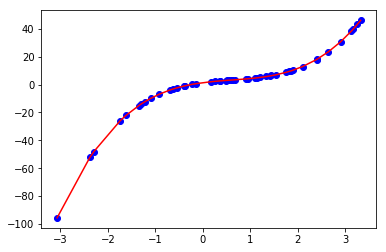

In [41]:
from scipy.interpolate import UnivariateSpline

Xr2 = Xr.flatten()
p = Xr2.argsort()
Xr2 = Xr2[p]
yr2 = yr[p]

clf = UnivariateSpline(Xr2, yr2, s=80)
preds = clf(Xr2)

utils.plot_reg(Xr2.reshape(-1, 1), yr2, preds)
plt.show()

# Nonparametric Logistic Regression

The smoothing spine problem can also be used with logistic regression:
    
$$\log \frac{P(Y=1|X=x)}{P(Y=0|X=x)} = f(x)$$
$$P(Y=1|X=x) = \frac{e^{f(x)}}{1 + e^{f(x)}}$$

We penalized loss is:

$$l(f;\lambda) = \sum_{i=1}^N (y_if(x_i) - \log(1 + e^{f(x_i)})) - \frac{1}{2} \lambda \int f''(t)^2dt$$

The optimal one is again $f$ a function representatic a natural cubic spine, with one knot of each of the $N$ points in $X$:

$$f(x) = \sum_{j=1}^N N_j(x)\theta_j$$

We cam compute the first and second derivates:

$$\frac{\partial l(\theta)}{\partial \theta} = N^T(y - p) - \lambda \Omega \theta$$
$$\frac{\partial^2 l(\theta)}{\partial \theta \partial \theta^T} = -N^TWN - \lambda \Omega$$

with :
- $N_{ij} = N_j(x_i)$ 
- $\Omega_{jk} = \int N_j''(t) N_k''(t)dt$
- $P_i = P(X = 1 | X = x_i)$
- $W_{ii} = P_i(1 - P_i)$$

Using Newton-Raphson, the predictions $f$ can be updated with:

$$f^\text{new} = N(N^TWN + \lambda\Omega)^{-1}N^TW(f^\text{old} + W^{-1}(y-p)) $$
$$f^\text{new} = S_{\lambda,w}z$$

It can be seen as a weigthed smoothing spine over working response $z$

# Multidimensional Spines

Let suppose $X \in \mathbb{R}^2$. We have a basic functions for both $X_1$ and $X_2$

$$h_{1k}(X_1), k=1,\text{...},M_1$$
$$h_{2k}(X_2), k=1,\text{...},M_2$$

There are the original spine or natural spine basis functions used in 1D.  
We can create new basis functions for 2D by combining them:

$$g_{jk}(X) = h_{1j}(X_1)h_{2k}(X_2)$$

$$f(X) = \sum_{j=1}^{M_1} \sum_{k=2}^{M_2} \beta_{jk} g_{jk}(X)$$

Accuracy: 0.95


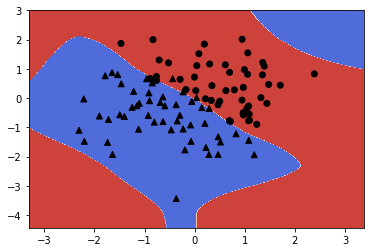

In [32]:
#spine of order 3 with 10 pieces

def spine_2d(X, inters, M):
    B0 = spline(X[:,0:1], inters, M)
    B1 = spline(X[:,1:2], inters, M)
    
    n = B0.shape[1]
    n = int(n * (n+1) / 2)
    B = np.empty((len(X), n))
    col = 0
    #B_ij and B_ji are the same, only compute one
    for i in range(B0.shape[1]):
        for j in range(B1.shape[1]):
            if i >= j:
                B[:,col] = B0[:,i]*B1[:,i]
                col+=1
                
    
    return B


def transf(X):
    return spine_2d(X, np.linspace(-4, 4, 10), 3)

Xe = transf(X)

clf = LogisticRegression(solver='liblinear')
clf.fit(Xe, y)

pred = clf.predict(Xe)
acc = np.mean(y == pred)
print('Accuracy:', acc)

utils.plot_contours(clf, X, xtrans=transf, 
                    cmap=plt.cm.coolwarm, alpha=1)
utils.plot_preds(X, y, pred)
plt.show()

Smoothing splines can also be extendent to multidimensions, with $x_i \in \mathbb{R}^d$. The seek the regressor function $f$:

$$\min_f \sum_{i=1}^N (y_i  f(x_i))^2 + \lambda J[f]$$

with J is a penanlty function, extending the 1D case.  
The 2d version is:

$$J[f] = \int \int_{\mathbb{R^2}} [(\frac{\partial^2 f(x)}{\partial x_1^2} )^2 + 2 * (\frac{\partial^2 f(x)}{\partial x_1 \partial x_2})^2 + (\frac{\partial^2 f(x)}{\partial x_2^2})^2]dx_1 dx_2$$

This lead to a smooth 2D surface going through all $x_i$, called a thin-plate spine.  
The solution has the form:
$$f(x) = \beta_0 + \beta^Tx \sum_{j=1}^N \alpha_j h_j(x)$$

with $h_j(x) = ||x - x_j||^2 \log (||x - x_j||)$

/home/aiw/rep/ml-notebooks/env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


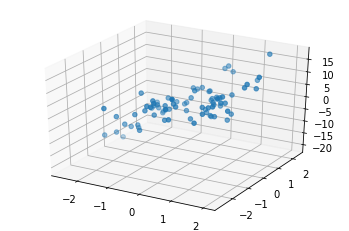

2.6411360293933877e-11


In [64]:


class SmoothingSpline2D:
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        P = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        K = np.empty((len(X), len(X)))
        for i in range(len(X)):
            for j in range(len(X)):
                d = np.linalg.norm(X[i] - X[j])
                K[i,j] = 0 if d < 1e-10 else d**2 * np.log(d)

        LHS = np.concatenate((P, K), axis=1)
        coeffs = np.linalg.lstsq(LHS, y)[0]
        
        self.X = X
        self.beta = coeffs[:3]
        self.alpha = coeffs[3:]
        
        
    def get_pred(self, x):
        res = self.beta[0]
        res += x @ self.beta[1:]
        
        for i in range(len(self.X)):
            d = np.linalg.norm(self.X[i] - x)
            d = 0 if d < 1e-10 else d**2 * np.log(d)
            res += d * self.alpha[i]
            
        return res
        
    def predict(self, X):
        y = np.empty((len(X),))
        for i in range(len(X)):
            y[i] = self.get_pred(X[i])
        return y


Xs = np.random.randn(80, 2)
ys = 1.1*Xs[:,0] + 1.4*Xs[:,1]**2 + 1.3*Xs[:,0]**3 + 3*np.random.randn(80)

clf = SmoothingSpline2D()
clf.fit(Xs, ys)
preds = clf.predict(Xs)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xs[:,0], Xs[:,1],ys)

plt.show()

print(metrics.tdist(preds, ys))

# Wavelet Smoothing

# B-Spline

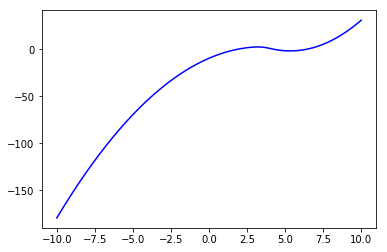

In [86]:
from scipy.interpolate import BSpline

k = 2
t = [0, 1, 2, 3, 4, 5, 6, 9]
c = [-1, 2, 3, -1, -2]

spl = BSpline(t, c, k)


xx = np.linspace(-10, 10, 1000)
plt.plot(xx, spl(xx), c='b')